# Computational Methods for Astrophysics, Homework #3, Askold Vilkha

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy import lambdify

## Exercise 1, Adaptive Runge-Kutta algorithm 

For this problem, we have to develop a code that implements adaptive Runge-Kutta algorithm. It will use 4th order accurate RK4 method for a single step. Runge-Kutta method is used to numerically evaluate the function $y(x)$ given by:
$$\frac{dy}{dx} = f(y, x)$$
Algorithm needs as input the function $f(y, x)$ and initial conditions $x_0$, $y_0 = y(x_0)$. Using that input and the step size $h$ chosen by user or automatically, RK4 can estimate values of the function $y(x)$ corresponding to $x$ values. The result will be a tabulated function $y(x)$ on the interval $[x_0, x_n]$. The algorithm will calculate weights $k_1, \dots, k_4$ based on the input:
$$k_1 = f(x_n, y_n) \\
k_2 = f(x_n + \frac{h}{2}, y_n + h\frac{k_1}{2}) \\
k_3 = f(x_n + \frac{h}{2}, y_n + h\frac{k_2}{2}) \\
k_4 = f(x_n + h, y_n + hk_3) \\
y_{n+1} = y_n + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)$$
$n$ here can start from $0$, when the user provides the initial conditions, and up to the value when $x_n$ reaches the end of the tabulation interval. This is implemented in `RK4_1st_order_step`. $\\$
For adaptive Runge-Kutta algorithm, the user provides tolerance, i. e., maximum allowed error. The algorithm then tries an initial step size $h_0$ defined either by user or calculated automatically based on the interval. With this step size $h_0$ it completes one RK4 step, and two steps with $h_0/2$. Difference of the estimated $y$ values is the local error. If it is less than tolerance, $h = h_0$, if not, the algorithm will assign a different step size $h$, a smaller one. Runge-Kutta truncation (local) accuracy order is $\sim O(h^5)$, so if the local error $\Delta$ is larger than tolerance $\text{tol}$, than the step size $h = h_0 \left|\frac{\text{tol}}{\Delta}\right|^{\frac{1}{5}} = h_0 \left|\frac{\text{tol}}{\Delta}\right|^{0.2}$. However, sometimes the step size could be too small, so the algorithm is very precise but computationally heavy. In that case, the step size will increase, since the factor by which we multiply original step size $h_0$ will be greater than $1$. This is implemented in `RK4_adaptive`.

For this problem, we have to solve a 2nd order ordinary differential equation (ODE):
$$y''(x) = -y, \quad y(0) = 10, \quad y'(0) = 1$$
RK4 method is designed to solve 1st order ODE, but it can be modified to work with 2nd order ones. Any 2nd order ODE can be transformed into a system of two 1st order ODEs by making a substitution $z = y'$. Then, the system of equations will be: 
$$ y' = z \\
z' = -y$$
To solve this using RK4 method, we need to define two functions instead of one of the original method:
$$f_1(y, z, x) = z \\
f_2(y, z, x) = -y$$
Therefore, the algorithm will be able to solve the system of equations and find $y$ and $z$ values. The RK4 method is then modified to work with two functions instead of one:
$$k_1 = f_1(x_n, y_n, z_n) \\
k_1' = f_2(x_n, y_n, z_n) \\
k_2 = f_1(x_n + \frac{h}{2}, y_n + h\frac{k_1}{2}, z_n + h\frac{k_1'}{2}) \\
k_2' = f_2(x_n + \frac{h}{2}, y_n + h\frac{k_1}{2}, z_n + h\frac{k_1'}{2}) \\
k_3 = f_1(x_n + \frac{h}{2}, y_n + h\frac{k_2}{2}, z_n + h\frac{k_2'}{2}) \\
k_3' = f_2(x_n + \frac{h}{2}, y_n + h\frac{k_2}{2}, z_n + h\frac{k_2'}{2}) \\
k_4 = f_1(x_n + h, y_n + hk_3, z_n + hk_3') \\
k_4' = f_2(x_n + h, y_n + hk_3, z_n + hk_3')$$
$y_{n+1}$ and $y'_{n+1}$ are calculated the same way as in the original RK4 method, but using the corresponding $k_1, \dots, k_4$ and $k_1', \dots, k_4'$. 
This is implemented in `RK4_2nd_order_step` function. $\\$ 

In [2]:
def test_ode_func(x, y, z):
    '''
    Test function for ODE. This is equivalent to the y'' = -y ODE.
    '''
    return -y

In [6]:
def test_ode_func_prime(x, y, z):
    '''
    Test function for ODE. This is equivalent to the y' = z ODE.
    '''
    return z

In [14]:
def RK4_1st_order_step(func, x_0: float, y_0: float, h: float):
    '''
    This function calculates a single step of the Runge-Kutta 4th order method for a first order ODE. Should be used as an auxillary function for `RK4_step` function.

    Parameters
    ----------
    func : function
        The function that defines the differential equation y' = f(x, y). Must require 2 arguments x, y.
    x_0 : float
        The initial value of x.
    y_0 : float
        The initial value of y.
    h : float
        The step size.

    Returns
    -------
    x_1 : float
        The value of x at x_0 + h.
    y_1 : float
        The value of y at x_0 + h.
    '''

    # RK coefficients k1, k2, k3, k4
    k_1 = func(x_0, y_0)
    k_2 = func(x_0 + h / 2, y_0 + h * k_1 / 2)
    k_3 = func(x_0 + h / 2, y_0 + h * k_2 / 2)
    k_4 = func(x_0 + h, y_0 + h * k_3)

    # resulting approximation of the step
    x_1 = x_0 + h
    y_1 = y_0 + (h / 6) * (k_1 + 2 * k_2 + 2 * k_3 + k_4)

    return x_1, y_1
    

In [13]:
def RK4_2nd_order_step(func, func_prime, x_0: float, y_0: float, y_0_prime: float, h: float):
    '''
    This function calculates a single step of modified Runge-Kutta method (RK4) for a second order ODE. Should be used as an auxiliary function for `RK4_step` function.

    Parameters
    ----------
    func : function
        The function that defines the differential equation y'' = f(x, y, y'). Must require 3 arguments x, y, z. z here is equivalent to y'.
    func_prime : function
        The function that defines the differential equation y' = f(x, y, y'). Must require 3 arguments x, y, z. z here is equivalent to y'.
    x_0 : float
        The initial value of x.
    y_0 : float
        The initial value of y.
    y_0_prime : float
        The initial value of y'.
    h : float
        The step size.

    Returns
    -------
    x_1 : float
        The value of x at x_0 + h.
    y_1 : float
        The value of y at x_0 + h.
    y_1_prime : float
        The value of y' at x_0 + h.
    '''

    # RK coefficients k1, k2, k3, k4
    k_1 = func_prime(x_0, y_0, y_0_prime)
    k_1_prime = func(x_0, y_0, y_0_prime)
    k_2 = func_prime(x_0 + h / 2, y_0 + h * k_1 / 2, y_0_prime + h * k_1_prime / 2)
    k_2_prime = func(x_0 + h / 2, y_0 + h * k_1 / 2, y_0_prime + h * k_1_prime / 2)
    k_3 = func_prime(x_0 + h / 2, y_0 + h * k_2 / 2, y_0_prime + h * k_2_prime / 2)
    k_3_prime = func(x_0 + h / 2, y_0 + h * k_2 / 2, y_0_prime + h * k_2_prime / 2)
    k_4 = func_prime(x_0 + h, y_0 + h * k_3, y_0_prime + h * k_3_prime)
    k_4_prime = func(x_0 + h, y_0 + h * k_3, y_0_prime + h * k_3_prime)

    # resulting approximation of the step
    x_1 = x_0 + h
    y_1 = y_0 + (h / 6) * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
    y_1_prime = y_0_prime + (h / 6) * (k_1_prime + 2 * k_2_prime + 2 * k_3_prime + k_4_prime)

    return x_1, y_1, y_1_prime

In [87]:
def RK4_adaptive_1st_order(func, bracket: list, x_0: float, y_0: float, h: float, tol: float, verbose: bool):
    '''
    This function calculates the solution of a first order ODE using the Runge-Kutta 4th order method with adaptive step size. 
    The step size is adjusted to keep the error below the tolerance level. 
    Also, the step size will be adjusted if the error is too small to avoid unnecessary calculations. The function must be provided in the format y' = f(x, y).
    Should be used as an auxiliary function for `RK4_adaptive` function.

    Parameters
    ----------
    func : function
        The function that defines the differential equation y' = f(x, y). Must require 2 arguments x, y.
    bracket : list
        The bracket for the solution. The solution will be calculated until x reaches the upper bound of the bracket.
    x_0 : float
        The initial value of x.
    y_0 : float
        The initial value of y.
    h : float   
        The initial step size. Must be positive.
    tol : float
        The tolerance level for the error. Must be positive.
    verbose : bool
        If True, the function will print the values of x, y and error at each step.

    Returns
    -------
    x_array : numpy.ndarray
        The array of x values.
    y_array : numpy.ndarray
        The array of y values.
    err_array : numpy.ndarray
        The array of errors.

    Raises
    ------
    ValueError
        If the step size or tolerance level is not positive.
    '''    
    if h is not None and h <=  0:
        raise ValueError(h, r'Step size h must be positive!')
    if tol <= 0:
        raise ValueError(tol, r'Tolerance tol must be positive!')

    # initialize variables
    x = x_0
    y = y_0

    # initialize arrays to store values
    x_array = np.array([x])
    y_array = np.array([y])
    err_array = np.array([0])
    
    # initialize error
    error = tol * 2
    
    while x < bracket[1] and error > tol:
        
        # take one step with step size h and two steps with step size h/2 and compare the results
        x_1, y_1 = RK4_1st_order_step(func, x, y, h)
        x_2, y_2 = RK4_1st_order_step(func, x, y, h/2)
        x_2, y_2 = RK4_1st_order_step(func, x_2, y_2, h/2)
        error = np.abs(y_2 - y_1) 

        # if error is too large, reduce step size and try again
        if error > tol:
            h = h * (tol / error) ** 0.2
            continue
        # if the error is too small, increase the step size and try again
        elif error != 0 and np.log10(error) - np.log10(tol) < -3:
            h = h * (tol / error) ** 0.2
            error = tol * 2 # reset error so the code goes through the loop again
            continue

        # if error is small enough, we accept the step and store the values
        x_array = np.append(x_array, x_1)
        y_array = np.append(y_array, y_1)
        err_array = np.append(err_array, error)

        if verbose:
            print(r'x = %g, y = %g, error = %g' % (x_1, y_1, error))

        # we set the starting point for the next step
        x = x_1
        y = y_1
        error = tol * 2

    return x_array, y_array, err_array

In [88]:
def RK4_adaptive_2nd_order(func, bracket: list, x_0: float, y_0: float, h: float, tol: float, func_prime, y_0_prime: float, verbose: bool):
    '''
    This function calculates the solution of a second order ODE using the Runge-Kutta 4th order method with adaptive step size. 
    The step size is adjusted to keep the error below the tolerance level. 
    Also, the step size will be adjusted if the error is too small to avoid unnecessary calculations.
    The function must be provided in the format y'' = f(x, y, y'). `func_prime` must be provided in the format y' = f(x, y, y'). 
    Should be used as an auxiliary function for `RK4_adaptive` function.

    Parameters
    ----------
    func : function
        The function that defines the differential equation y'' = f(x, y, y'). Must require 3 arguments x, y, z. z here is equivalent to y'.
    bracket : list
        The bracket for the solution. The solution will be calculated until x reaches the upper bound of the bracket.
    x_0 : float
        The initial value of x.
    y_0 : float
        The initial value of y.
    h : float
        The initial step size. Must be positive.
    tol : float
        The tolerance level for the error. Must be positive.
    func_prime : function
        The function that defines the differential equation y' = f(x, y, y'). Must require 3 arguments x, y, z. z here is equivalent to y'.
    y_0_prime : float
        The initial value of y'.
    verbose : bool
        If True, the function will print the values of x, y, y' and errors at each step.
    
    Returns
    ------- 
    x_array : numpy.ndarray
        The array of x values.
    y_array : numpy.ndarray
        The array of y values.
    y_prime_array : numpy.ndarray
        The array of y' values.
    err_array : numpy.ndarray
        The array of errors.
    err_prime_array : numpy.ndarray
        The array of errors for y'.

    Raises
    ------
    ValueError
        If the step size or tolerance level is not positive.    
    '''
    if h is not None and h <=  0:
        raise ValueError(h, r'Step size h must be positive!')
    if tol <= 0:
        raise ValueError(tol, r'Tolerance tol must be positive!')

    # initialize variables
    x = x_0
    y = y_0
    y_prime = y_0_prime

    # initialize arrays to store values
    x_array = np.array([x])
    y_array = np.array([y])
    y_prime_array = np.array([y_prime])
    err_array = np.array([0])
    err_prime_array = np.array([0])

    # initialize error
    error = tol * 2

    while x < bracket[1] and error > tol:
        # take one step with step size h and two steps with step size h/2 and compare the results
        x_1, y_1, y_1_prime = RK4_2nd_order_step(func, func_prime, x, y, y_prime, h)
        x_2, y_2, y_2_prime = RK4_2nd_order_step(func, func_prime, x, y, y_prime, h/2)
        x_2, y_2, y_2_prime = RK4_2nd_order_step(func, func_prime, x_2, y_2, y_2_prime, h/2)
        error = np.abs(y_2 - y_1) 

        # if error is too large, reduce step size and try again
        if error > tol:
            h = h * (tol / error) ** 0.2
            continue
        # if the error is too small, increase the step size and try again
        elif error != 0 and np.log10(error) - np.log10(tol) < -3:
            h = h * (tol / error) ** 0.2
            error = tol * 2 # reset error so the code goes through the loop again
            continue
            
        # if error is small enough, we accept the step and store the values
        x_array = np.append(x_array, x_1)
        y_array = np.append(y_array, y_1)
        err_array = np.append(err_array, error)
        y_prime_array = np.append(y_prime_array, y_1_prime)
        err_prime_array = np.append(err_prime_array, np.abs(y_2_prime - y_1_prime))

        if verbose:
            print(r'x = %g, y = %g, y_prime = %g, error = %g, error_prime = %g' % (x_1, y_1, y_1_prime, error, np.abs(y_2_prime - y_1_prime)))
            
        # we set the starting point for the next step
        x = x_1
        y = y_1
        y_prime = y_1_prime
        error = tol * 2
    
    return x_array, y_array, y_prime_array, err_array, err_prime_array

In [114]:
def RK4_adaptive(func, bracket: list, x_0: float = 0, y_0: float = 10, h_0: float = None, tol: float = 1e-14, func_prime = None, y_0_prime: float = 1, verbose: bool = False):
    '''
    This function implements the adaptive Runge-Kutta algorithm to numerically evaluate the function y(x) given by 1st or 2nd order ODE. 
    If the problem is 1st order ODE, the function must be provided in the format y' = f(x, y). 
    If the problem is 2nd order ODE, the function must be provided in the format y'' = f(x, y, y'). 
    This function will determine if the problem is 1st or 2nd order ODE automatically based on the input parameters. 
    If `func_prime` is provided, the problem is assumed to be 2nd order ODE.
    
    Parameters
    ----------
    func : function
        A function to be solved by the algorithm. This function should be obtained from ODE in the format y' = f(x, y), if the problem is 1st order ODE. 
        The function must require only 2 arguments x and y, if `func_prime` is not provided. I. e. user wants to solve 1st order ODE. 
        For second order ODE, the function must require 3 arguments x, y, z. y' is represented by y' = z, where z is the third argument. 
        For 2nd order ODE, this function must be equivalent to y'' = f(x, y, y').
    bracket : list
        The bracket for the solution. The solution will be calculated until x reaches the upper bound of the bracket.
    x_0 : float, optional
        The initial value of x variable, by default 0 (for our exersise problem)
    y_0 : float, optional
        The initial value of y variable, by default 10 (for our exersise problem)
    h_0 : float, optional
        Initial step size, by default None. If None, the algorithm will start with an automatic guess.
    tol : float, optional
        Maximum allowed error, by default 1e-14. 
        Even though 1e-16 is the machine precision, the tests have shown that the computational cost is too high for such a small tolerance level.
    func_prime : function, optional
        An additional function for solving 2nd order ODE. This function should be obtained from ODE in the format y' = f(x, y, y'). Must require 3 arguments x, y, z.
        z here is the third argument, which is equivalent to y'. The default is `None`. If `None`, the problem is assumed to be 1st order ODE.
    y_0_prime : float, optional
        The initial value of y' variable. Must be provided if `func_prime` is provided. The default is 1 (for our exercise problem). 
        If `func_prime` is provided, `y_0_prime` must be provided as well.

    Returns
    -------
    x_array : numpy.ndarray
        The array of x values.
    y_array : numpy.ndarray
        The array of y values.
    err_array : numpy.ndarray
        The array of errors.
    y_prime_array : numpy.ndarray
        The array of y' values. Only returned if `func_prime` is provided.
    err_prime_array : numpy.ndarray
        The array of errors for y'. Only returned if `func_prime` is provided.

    Raises
    ------
    ValueError
        If the step size h_0 or tolerance tol is not positive.
    ValueError
        If `func_prime` is provided, but `y_0_prime` is not provided and vice versa.
    '''
    if h_0 is not None and h_0 <=  0:
        raise ValueError(h_0, r'Step size h must be positive!')
    if tol <= 0:
        raise ValueError(tol, r'Tolerance tol must be positive!')
    if (func_prime is not None) != (y_0_prime is not None):
        raise ValueError("If func_prime is provided, y_0_prime must be provided as well and vice versa!")
    
    # if initial step size h_0 is not specified by user, the code will start with an initial automatic guess
    if h_0 == None:
        h_0 = (bracket[1] - bracket[0]) / 1e5

    if func_prime is None:
        return RK4_adaptive_1st_order(func, bracket, x_0, y_0, h_0, tol, verbose)
    else:
        return RK4_adaptive_2nd_order(func, bracket, x_0, y_0, h_0, tol, func_prime, y_0_prime, verbose)

Now that we have a code that can solve ODEs, we can test it on the examples that we know the analytical solutions for. For the first example, we will use the following ODE:
$$y' = 5y - 3, \quad y(2) = 1$$
We will solve the equation analytically and compare the result with the numerical solution. For analytical solution, we will use the computer algebra package `sympy`.  Specifically, we use the function `dsolve` to solve the ODE. The result is:
$$y(x) = \frac{3}{5} + \frac{2}{5}e^{5(x - 2)}$$

In [109]:
# define symbols
x_sym = symbols('x')
y_sym = Function('y')(x_sym)
y_prime_sym = y_sym.diff(x_sym)

# define and solve ODE
ode_1st_order = Eq(y_prime_sym, 5 * y_sym - 3)
sol_1st_order = dsolve(ode_1st_order, ics = {y_sym.subs(x_sym, 2): 1})
print(r'1st order ODE solution: %s' % sol_1st_order)

1st order ODE solution: Eq(y(x), 2*exp(-10)*exp(5*x)/5 + 3/5)


Now we can plot the numerical and analytical solutions and compare them. The plot is shown below in Fig. 1.

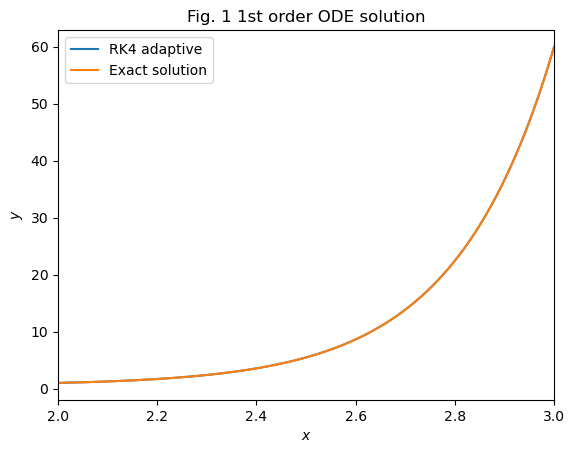

In [117]:
x_test_1st_order, y_test_1st_order, err_test_1st_order = RK4_adaptive(func = lambda x, y: 5 * y - 3, bracket = [2, 3], x_0 = 2, y_0 = 1, func_prime = None, y_0_prime = None)
sol_1st_order_func = lambdify(x_sym, sol_1st_order.rhs)
plt.plot(x_test_1st_order, y_test_1st_order, label = r'RK4 adaptive')
plt.plot(x_test_1st_order, sol_1st_order_func(x_test_1st_order), label = r'Exact solution')
plt.xlim(2, 3)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.legend()
plt.title(r'Fig. 1 1st order ODE solution');

As we can see, the numerical solution coincides with the analytical one. The error is very small, so it is not visible on the plot. $\\$ Therefore, we can plot the error itself. The plot is shown below in Fig. 2.

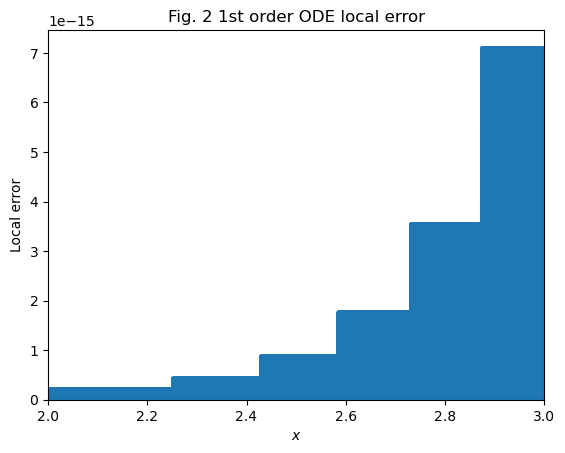

In [123]:
plt.plot(x_test_1st_order, err_test_1st_order)
plt.xlim(2, 3); plt.ylim(bottom = 0)
plt.xlabel(r'$x$'); plt.ylabel(r'Local error')
plt.title(r'Fig. 2 1st order ODE local error');

In [119]:
L_inf_err_1st_order = np.max(err_test_1st_order)
print(r'1st order ODE L_inf error: %g' % L_inf_err_1st_order)

1st order ODE L_inf error: 7.10543e-15


The error increases as $y$ increases, but it is still very small and does not exceed tolerance ($10^{-14}$).  $L^{\infty}$ norm of the error is of the order $10^{-15}$.However this plot only shows the local error of the algorithm. The actual error can be calculated by comparing the numerical solution with the analytical one. The plot is shown below in Fig. 3.

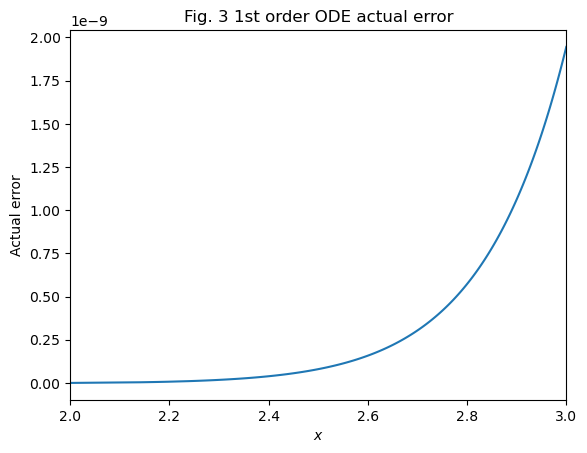

In [126]:
plt.plot(x_test_1st_order, np.abs(y_test_1st_order - sol_1st_order_func(x_test_1st_order)))
plt.xlabel(r'$x$'); plt.ylabel(r'Actual error')
plt.xlim(2, 3)
plt.title(r'Fig. 3 1st order ODE actual error');

In [127]:
L_inf_err_1st_order_actual = np.max(np.abs(y_test_1st_order - sol_1st_order_func(x_test_1st_order)))
print(r'1st order ODE L_inf actual error: %g' % L_inf_err_1st_order_actual)

1st order ODE L_inf actual error: 1.94503e-09


The actual error is larger by 6 orders, but still is very small. $L_{\infty}$ norm of the error is of the order $10^{-9}$. $\\$
Now we can test our algorithm on the 2nd order ODE. We will use the following ODE:
$$y'' = -y, \quad y(0) = 10, \quad y'(0) = 1$$
We can solve this analytically and compare the result with the numerical solution. The analytical solution is obtained using `sympy` package. The result is:
$$y(x) = 10\cos(x) + \sin(x)$$

In [128]:
# define and solve the ODE
ode_2nd_order = Eq(y_prime_sym.diff(x_sym) + y_sym, 0)
sol_2nd_order = dsolve(ode_2nd_order, ics={y_sym.subs(x_sym, 0): 10, y_prime_sym.subs(x_sym, 0): 1})
print(r'2nd order ODE solution: %s' % sol_2nd_order)

2nd order ODE solution: Eq(y(x), sin(x) + 10*cos(x))


Now we can plot the analytical and the numerical solutions and compare them. The plot is shown below in Fig. 4.

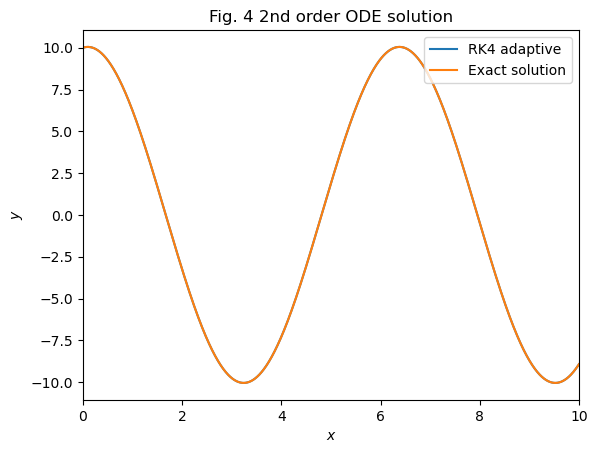

In [130]:
x_test, y_test, y_prime_test, err_test, err_prime_test = RK4_adaptive(func = test_ode_func, bracket = [0, 10], x_0 = 0, y_0 = 10, func_prime = test_ode_func_prime, y_0_prime = 1)
sol_2nd_order_func = lambdify(x_sym, sol_2nd_order.rhs)
plt.plot(x_test, y_test, label = r'RK4 adaptive')
plt.plot(x_test, sol_2nd_order_func(x_test), label = r'Exact solution')
plt.xlim(0, 10)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.legend()
plt.title(r'Fig. 4 2nd order ODE solution');

Again, the numerical solution is very close to the analytical, so we can not distinguish them on the plot. We can plot the local error of the algorithm and calculate $L^{\infty}$ norm of the error. The plot is shown below in Fig. 5.

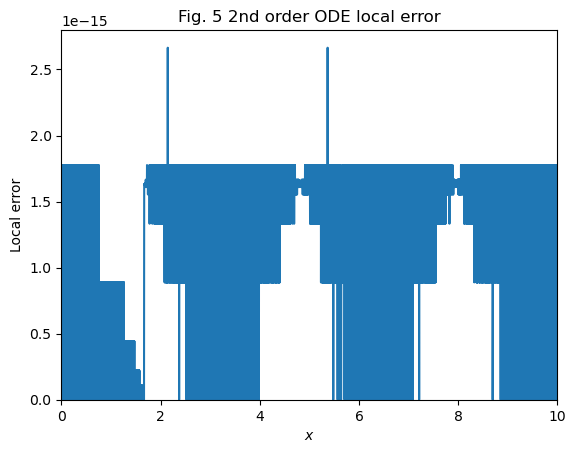

In [131]:
plt.plot(x_test, err_test)
plt.xlim(0, 10); plt.ylim(bottom = 0)
plt.xlabel(r'$x$'); plt.ylabel(r'Local error')
plt.title(r'Fig. 5 2nd order ODE local error');

In [132]:
L_inf_err = np.max(err_test)
print(r'2nd order ODE L_inf error: %g' % L_inf_err)

2nd order ODE L_inf error: 2.66454e-15


The local error is very small, and does not exceed tolerance ($10^{-14}$). $L^{\infty}$ norm of the error is of the order $10^{-15}$. $\\$ 
Now we can plot the actual error of the algorithm. The plot is shown below in Fig. 6.

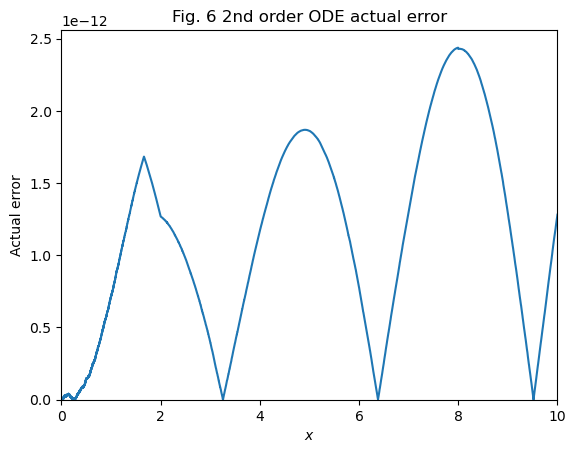

In [137]:
plt.plot(x_test, np.abs(y_test - sol_2nd_order_func(x_test)))
plt.xlabel(r'$x$'); plt.ylabel(r'Actual error')
plt.xlim(0, 10); plt.ylim(bottom = 0)
plt.title(r'Fig. 6 2nd order ODE actual error');

In [134]:
L_inf_err_actual = np.max(np.abs(y_test - sol_2nd_order_func(x_test)))
print(r'2nd order ODE L_inf actual error: %g' % L_inf_err_actual)

2nd order ODE L_inf actual error: 2.43655e-12


Actual error is larger than the local, but is still very small (of the order $10^{-12}$) and does not exceed tolerance ($10^{-14}$). $L^{\infty}$ norm of the error is of the order $10^{-12}$. $\\$ 
We can perform similar tests with the derivative of the test function, since the algorithm returns it as well. This is shown on the plots below in Fig. 7-9.

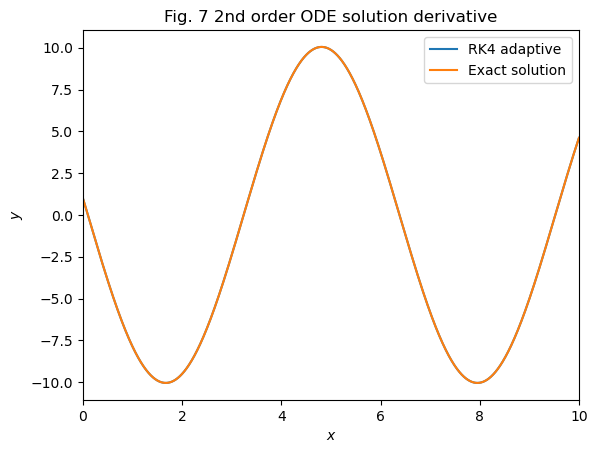

In [135]:
sol_2nd_order_deriv_func = lambdify(x_sym, sol_2nd_order.rhs.diff(x_sym))
plt.plot(x_test, y_prime_test, label = r'RK4 adaptive')
plt.plot(x_test, sol_2nd_order_deriv_func(x_test), label = r'Exact solution')
plt.xlim(0, 10)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.legend()
plt.title(r'Fig. 7 2nd order ODE solution derivative');

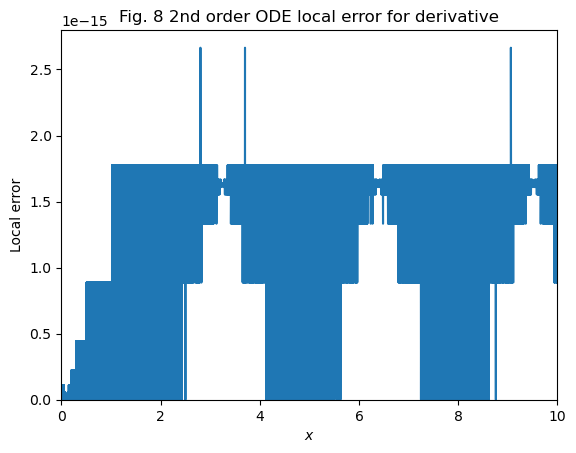

In [136]:
plt.plot(x_test, err_prime_test)
plt.xlim(0, 10); plt.ylim(bottom = 0)
plt.xlabel(r'$x$'); plt.ylabel(r'Local error')
plt.title(r'Fig. 8 2nd order ODE local error for derivative');

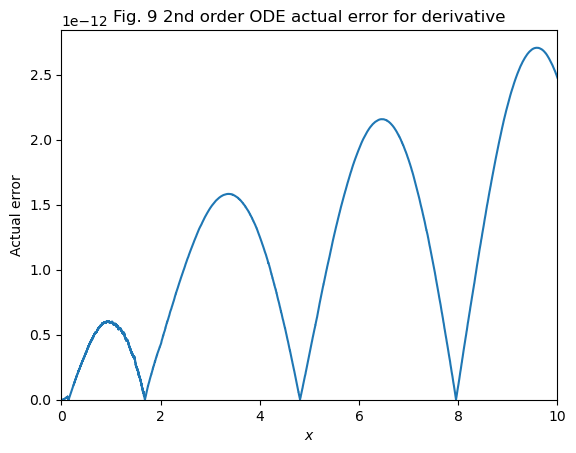

In [138]:
plt.plot(x_test, np.abs(y_prime_test - sol_2nd_order_deriv_func(x_test)))
plt.xlabel(r'$x$'); plt.ylabel(r'Actual error')
plt.xlim(0, 10); plt.ylim(bottom = 0)
plt.title(r'Fig. 9 2nd order ODE actual error for derivative');

Errors show very similar behavior as in the case of the function itself. 